In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100

import geopandas as gpd

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


from os import listdir
import unicodedata


from paths import *
# from scripts.vis_graphs import remove_acentos
# from scripts.vis_graphs import normalize_cols
from scripts.io import read_sheets
from scripts import vis_maps
from scripts import vis_taubate


from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')


import yaml
config = yaml.load(open('../configs/config_taubate.yaml', 'r') ,Loader = yaml.FullLoader)


## Load Data

In [2]:
def padronize_bairros(df_cases):
    
    df_cases['bairro'] = df_cases['bairro'].str.replace('Jd ', 'Jardim ').str.replace('Pq ', 'Parque ').str.replace('Res. ', 'Residencial ')
    rename_bairros = {
         'Cecap 3' : 'Cecap',
         'Cecap 4' : 'Cecap',
         'Chácara Hopólito' : 'Chácara Hipólito',
         'Jardim do Lago' : 'Jardim dos Lagos',
         'Parque Tres Marias' : 'Parque Três Marias',
         'Vila dos Comerciarios' : 'Vila dos Comerciários',
         'Vila dos Comerciários II' :'Vila dos Comerciários',
         'Flamboyabt':'Barranco',
    }

    df_cases['bairro'] = df_cases['bairro'].replace(rename_bairros)
    
    return df_cases

In [3]:
## load cases table
df_cases = read_sheets('covid19_taubate')

##padronize bairros names
df_cases = padronize_bairros(df_cases)
bairos = list(np.sort(df_cases['bairro'].unique()))

#load neighborhood lat lon
df_bairos = read_sheets('covid19_taubate', 'bairros')
bairos_latlon = df_bairos.bairro.tolist()

#chek if all neighborhood had a lat lon
compare_bairos = [bairo for bairo in bairos if bairo not in bairos_latlon]
compare_bairos

[]

In [4]:
# bairos = df_cases[['bairro']].drop_duplicates()
# bairos.merge(df_bairos, on='bairro', how='outer').sort_values(by='bairro').to_csv('bairros.csv', index=False)

In [5]:
df = df_cases.copy()
mask = df['status'].isin(['analise','confirmado','obito','descartado'])
df = df[mask]
    
## prepare data
df = df.merge(df_bairos, on='bairro', how='left')

mask = ((df['status']!='xxx') & (df['lat_lon']!='xxx'))
df = df[mask]

df['lat'] = df['lat_lon'].apply(lambda x: x.split(',')[0]).astype(float)
df['lon'] = df['lat_lon'].apply(lambda x: x.split(',')[1]).astype(float)

df['data'] = pd.to_datetime(df['data'], format = "%d/%m/%Y")

## Map

In [72]:

import folium

status_adjusts = {
    'analise':{
        'color':'#EF9B0F',             
        'text':"<b>Bairro:</b> {} <br> <br> <b>Casos em Análise:</b> {}" ### nome do bairro e quantidade da metrica
    },
    'confirmado':{
        'color':'red',             
        'text':"<b>Bairro:</b> {} <br> <br> <b>Casos Confirmados:</b> {}"
    },
    'obito':{
        'color':'black',             
        'text':"<b>Bairro:</b> {} <br> <br> <b>Óbitos:</b> {}"
    },
    
    'descartado':{
        'color':'green',             
        'text':"<b>Bairro:</b> {} <br> <br> <b>Casos Descartados:</b> {}"
    },
}

config['taubate_map']

# mask_descartados = ((df['status']!='descartado') & (df['bairro']=='Vila São José'))
mask_descartados = ((df['status']!='descartado'))
m = vis_taubate.get_map_taubate(df[mask_descartados], status_adjusts, config['taubate_map'], save=True)

In [73]:
m

In [8]:
# m.save('mapa_taubate.html')
# m

## Sex

In [65]:
confirmados = df.query("status=='confirmado' | status=='obito'")
confirmados['sexo'] = confirmados['sexo'].str.replace('F','Feminino').str.replace('M','Masculino')

In [66]:
themes = yaml.load(open('../themes/themes_taubate.yaml', 'r') ,Loader = yaml.FullLoader)



fig = vis_taubate.taubate_pie(confirmados, themes['taubate_pie'], config['taubate_sexo'], save=True)

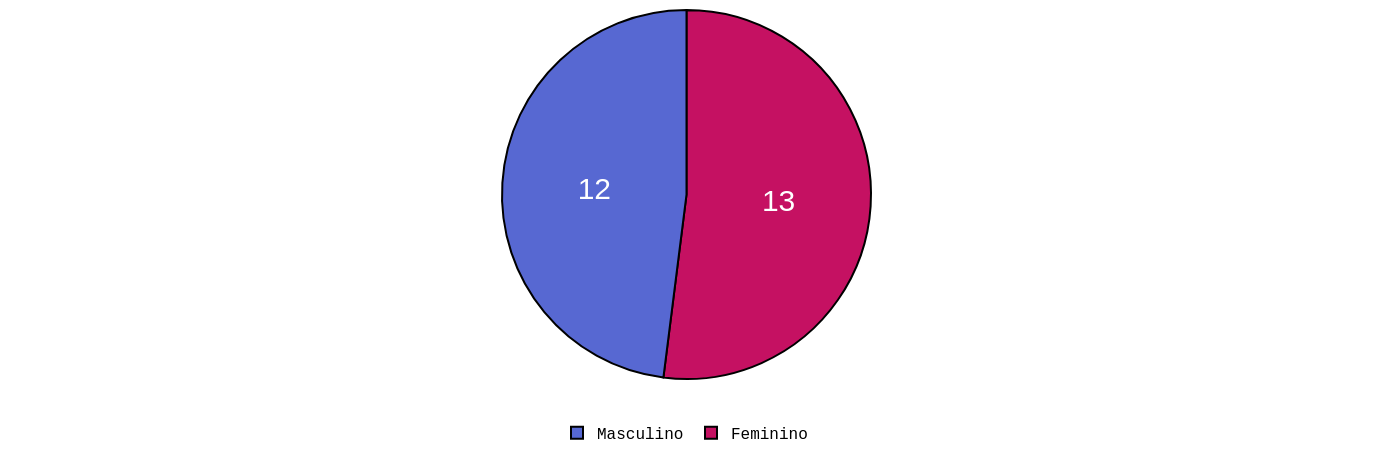

In [67]:
fig

## Age

In [68]:
from scripts import io
themes = yaml.load(open('../themes/themes_taubate.yaml', 'r') ,Loader = yaml.FullLoader)

fig = vis_taubate.taubate_faixas(confirmados, themes['taubate_faixas'], config['taubate_faixa_etaria'], save=True)

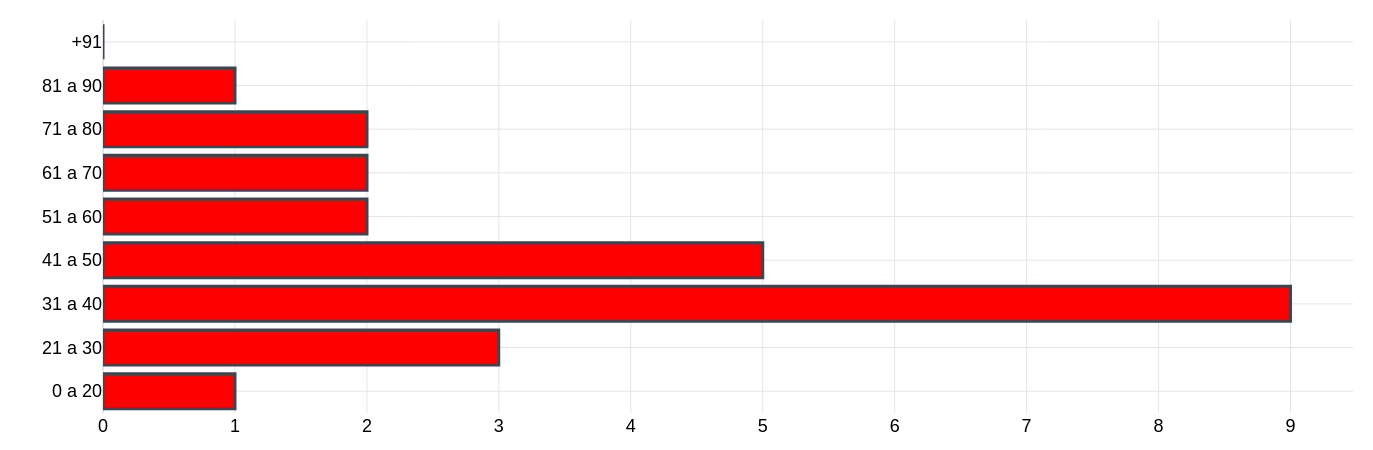

In [69]:
fig

## Evolution

In [137]:
tb_cases = read_sheets('covid19_taubate', 'evolucao')
tb_cases['data'] = pd.to_datetime(tb_cases['data'], format = "%d/%m/%Y")
tb_cases = tb_cases.sort_values(by='data', ascending=True)

for col in tb_cases.columns[1:]:
    tb_cases[col] = pd.to_numeric(tb_cases[col])
    
for col in ['analise','confirmado','descartado','obito','internado','em_analise']:
   
    tb_cases[f'{col}_day'] = tb_cases[col] - tb_cases[col].shift(1).fillna(0)
    tb_cases[f'{col}_day'] = tb_cases[f'{col}_day'].astype(int)

cols = ['data'] + np.sort(tb_cases.columns[1:]).tolist()
tb_cases = tb_cases[cols]

In [139]:
from scripts import vis_taubate
themes = yaml.load(open('../themes/themes_taubate.yaml', 'r') ,Loader = yaml.FullLoader)
config = yaml.load(open('../configs/config_taubate.yaml', 'r') ,Loader = yaml.FullLoader)

adjusts = {
    'obito_day': {'nome':'Óbitos','cor':'black'    },
    'confirmado_day': {'nome':'Confirmados','cor':'red'    },
    'analise_day'   : {'nome':'Exames Colhidos' ,'cor':'#EF9B0F'},
#     'descartado_day': {'nome':'Descartados','cor':'green'  },

}

fig = vis_taubate.taubate_daily(tb_cases,themes['taubate'], adjusts, config['taubate_daily'],save=True)

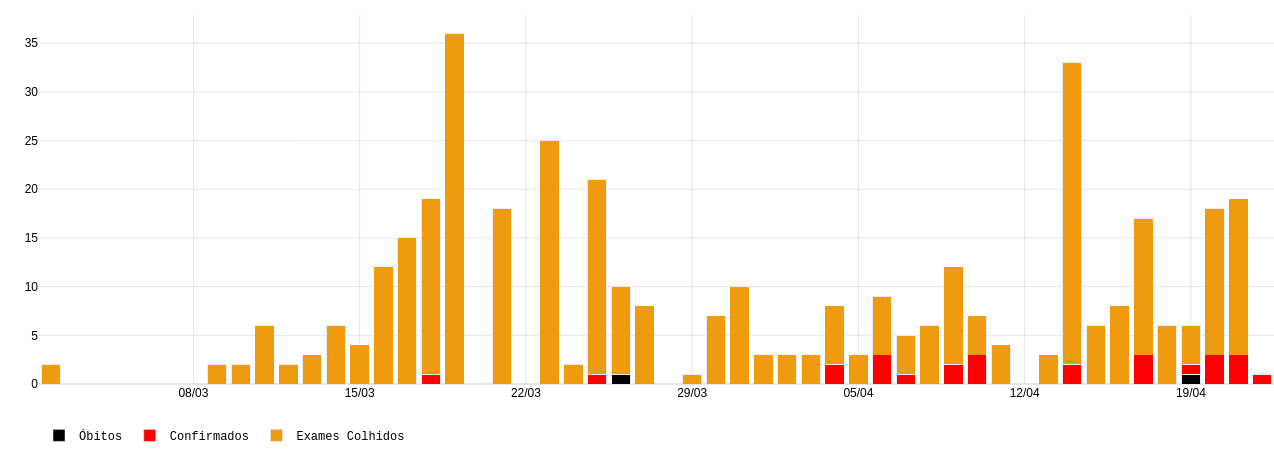

In [140]:
fig

In [141]:
from scripts import vis_layout
from scripts import vis_taubate

themes = yaml.load(open('../themes/themes_taubate.yaml', 'r') ,Loader = yaml.FullLoader)
config = yaml.load(open('../configs/config_taubate.yaml', 'r') ,Loader = yaml.FullLoader)

adjusts = {
    'obito'     : {'nome':'Óbitos',          'cor':'black',   'visible':True},
    'confirmado': {'nome':'Confirmados',     'cor':'red'    , 'visible':True},
    'internado' : {'nome':'Internados',       'cor':'purple'  ,'visible':True},
#     'analise'   : {'nome':'Exames Colhidos' ,'cor':'#EF9B0F', 'visible':'legendonly'},
}

fig = vis_taubate.taubate_cum(tb_cases,
                              themes['taubate'], adjusts, config['taubate_cumulative'],save=True)

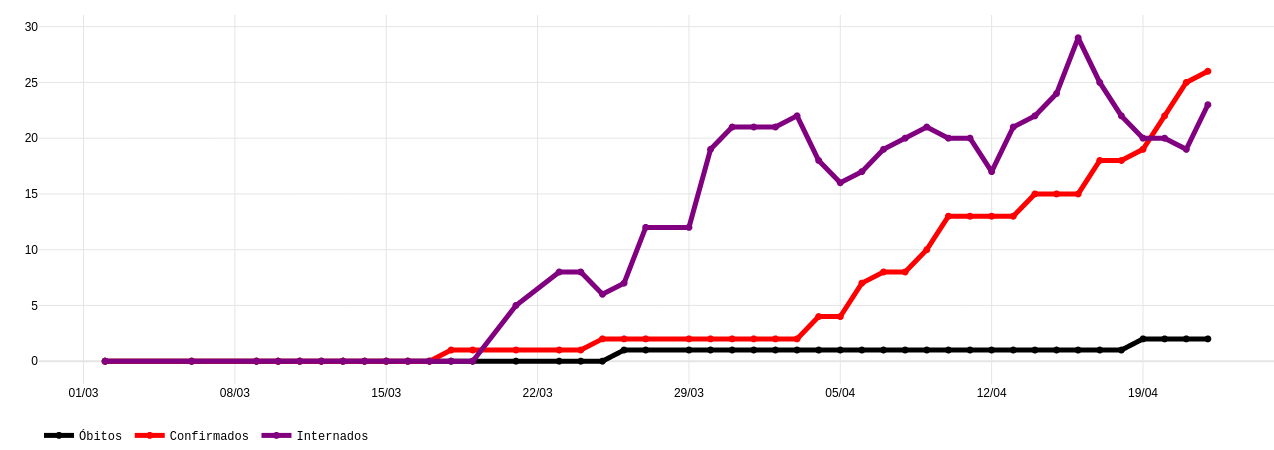

In [142]:
fig

In [143]:
from scripts import vis_taubate

In [146]:
config = yaml.load(open('../configs/config_taubate.yaml', 'r') ,Loader = yaml.FullLoader)
vis_taubate.taubate_update_html(tb_cases, config['embed_html'], save=True)

In [147]:
#https://pypi.org/project/ftpretty/
from ftpretty import ftpretty
import ftplib
import yaml
import os
config = yaml.load(open('../../credentials/ftp_credentials.yaml', 'r'), Loader=yaml.FullLoader)


In [148]:
host = config['ftp']['host']
user = config['ftp']['user']
pw   = config['ftp']['pw']

f = ftpretty(host, user, pw)

### Upload taubate site

In [149]:
%%time
local_folder  = '../site/sv_taubate/coronataubate'
remote_folder = 'public_html/coronataubate'

f.upload_tree(local_folder, remote_folder)

CPU times: user 70.5 ms, sys: 21.5 ms, total: 91.9 ms
Wall time: 51.1 s


'public_html/coronataubate'